In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import f1_score,accuracy_score, confusion_matrix, classification_report
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/content/dataset.csv') #Load a dataset in dataframe name df
df.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fungal infection,itching,skin_rash,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.shape

(4920, 18)

In [4]:
df.info() #Give me some information about data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4920 entries, 0 to 4919
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Disease     4920 non-null   object
 1   Symptom_1   4920 non-null   object
 2   Symptom_2   4920 non-null   object
 3   Symptom_3   4920 non-null   object
 4   Symptom_4   4572 non-null   object
 5   Symptom_5   3714 non-null   object
 6   Symptom_6   2934 non-null   object
 7   Symptom_7   2268 non-null   object
 8   Symptom_8   1944 non-null   object
 9   Symptom_9   1692 non-null   object
 10  Symptom_10  1512 non-null   object
 11  Symptom_11  1194 non-null   object
 12  Symptom_12  744 non-null    object
 13  Symptom_13  504 non-null    object
 14  Symptom_14  306 non-null    object
 15  Symptom_15  240 non-null    object
 16  Symptom_16  192 non-null    object
 17  Symptom_17  72 non-null     object
dtypes: object(18)
memory usage: 692.0+ KB


In [5]:
df.isnull().sum().sum() # Check if there is data contain NaN values or not

np.int64(46992)

In [6]:
df.describe() # Make basic statistical

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
count,4920,4920,4920,4920,4572,3714,2934,2268,1944,1692,1512,1194,744,504,306,240,192,72
unique,41,34,48,54,50,38,32,26,21,22,21,18,11,8,4,3,3,1
top,Fungal infection,vomiting,vomiting,fatigue,high_fever,headache,nausea,abdominal_pain,abdominal_pain,yellowing_of_eyes,yellowing_of_eyes,irritability,malaise,muscle_pain,chest_pain,chest_pain,blood_in_sputum,muscle_pain
freq,120,822,870,726,378,348,390,264,276,228,198,120,126,72,96,144,72,72


In [7]:
# Create a copy of the original dataframe to avoid modifying it directly
df = df.copy()

# Identify all columns in the dataframe except the 'Disease' column (these are the symptom columns)
symptom_cols = [col for col in df.columns if col != 'Disease']

# Combine all symptom values from the symptom columns into a single string per row, separated by commas
# This also drops any missing (NaN) values before joining
df['All Symptoms'] = df[symptom_cols].apply(lambda row: ','.join(row.dropna()), axis=1)

# Split the comma-separated symptom string into individual symptoms, remove duplicates using set(),
# sort them alphabetically for consistency, and then join them back into a string
df['All Symptoms'] = df['All Symptoms'].apply(lambda x: ','.join(sorted(set(x.split(',')))) if x else '')

# Keep only the 'Disease' and the newly created 'All Symptoms' columns in the final dataframe
df = df[['Disease', 'All Symptoms']]

In [8]:
df['All Symptoms'][0]

' dischromic _patches, nodal_skin_eruptions, skin_rash,itching'

In [9]:
df

,Disease,All Symptoms
0,Fungal infection,"dischromic _patches, nodal_skin_eruptions, sk..."
1,Fungal infection,"dischromic _patches, nodal_skin_eruptions, sk..."
2,Fungal infection,"dischromic _patches, nodal_skin_eruptions,itc..."
3,Fungal infection,"dischromic _patches, skin_rash,itching"
4,Fungal infection,"nodal_skin_eruptions, skin_rash,itching"
...,...,...
4915,(vertigo) Paroymsal Positional Vertigo,"headache, loss_of_balance, nausea, spinning_m..."
4916,Acne,"blackheads, pus_filled_pimples, scurring, ski..."
4917,Urinary tract infection,"bladder_discomfort, burning_micturition, cont..."
4918,Psoriasis,"inflammatory_nails, joint_pain, silver_like_d..."


In [10]:
df.isnull().sum().sum()

np.int64(0)

In [11]:
# Define a function to clean and tokenize symptom strings
def strip_to_basic_tokens(text):
    # Replace underscores and multiple spaces with a single space
    text = re.sub(r'[_\s]+', ' ', text)
    # Split the cleaned text by commas, strip whitespace from each token, and convert to lowercase
    tokens = [token.strip().lower() for token in text.split(',')]
    return tokens

# Apply the cleaning and tokenization function to the 'All Symptoms' column
df['Basic Tokens'] = df['All Symptoms'].apply(strip_to_basic_tokens)

# Convert the list of tokens back into a comma-separated string for easier viewing/storage
df['Basic Tokens'] = df['Basic Tokens'].apply(lambda x: ', '.join(x))

# Drop the original 'All Symptoms' column as it is no longer needed
df = df.drop(['All Symptoms'], axis=1)

# Display the first few rows of the updated DataFrame to verify the changes
df

,Disease,Basic Tokens
0,Fungal infection,"dischromic patches, nodal skin eruptions, skin..."
1,Fungal infection,"dischromic patches, nodal skin eruptions, skin..."
2,Fungal infection,"dischromic patches, nodal skin eruptions, itching"
3,Fungal infection,"dischromic patches, skin rash, itching"
4,Fungal infection,"nodal skin eruptions, skin rash, itching"
...,...,...
4915,(vertigo) Paroymsal Positional Vertigo,"headache, loss of balance, nausea, spinning mo..."
4916,Acne,"blackheads, pus filled pimples, scurring, skin..."
4917,Urinary tract infection,"bladder discomfort, burning micturition, conti..."
4918,Psoriasis,"inflammatory nails, joint pain, silver like du..."


In [12]:
df['Basic Tokens'][0]

'dischromic patches, nodal skin eruptions, skin rash, itching'

In [13]:
#make OneHot Encoder by using MultiLabelBinarizer because the data become tokens:
dfE = df.copy() # Taking a copy because we never know what might happen
dfE['Basic Tokens'] = dfE['Basic Tokens'].apply(lambda x: x.split(', '))
mlb = MultiLabelBinarizer()
one_hot_encoded = pd.DataFrame(mlb.fit_transform(dfE['Basic Tokens']), columns=mlb.classes_, index=df.index)


# Concatenate the one-hot encoded DataFrame with the original DataFrame
df_encoded = pd.concat([dfE, one_hot_encoded], axis=1)
# Drop the 'Basic Tokens' column
df_encoded = df_encoded.drop(columns=['Basic Tokens'])
df_encoded.head()

,Disease,abdominal pain,abnormal menstruation,acidity,acute liver failure,altered sensorium,anxiety,back pain,belly pain,blackheads,...,vomiting,watering from eyes,weakness in limbs,weakness of one body side,weight gain,weight loss,yellow crust ooze,yellow urine,yellowing of eyes,yellowish skin
0,Fungal infection,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Fungal infection,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Fungal infection,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Fungal infection,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Fungal infection,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4920 entries, 0 to 4919
Columns: 132 entries, Disease to yellowish skin
dtypes: int64(131), object(1)
memory usage: 5.0+ MB


In [15]:
df_encoded.shape

(4920, 132)

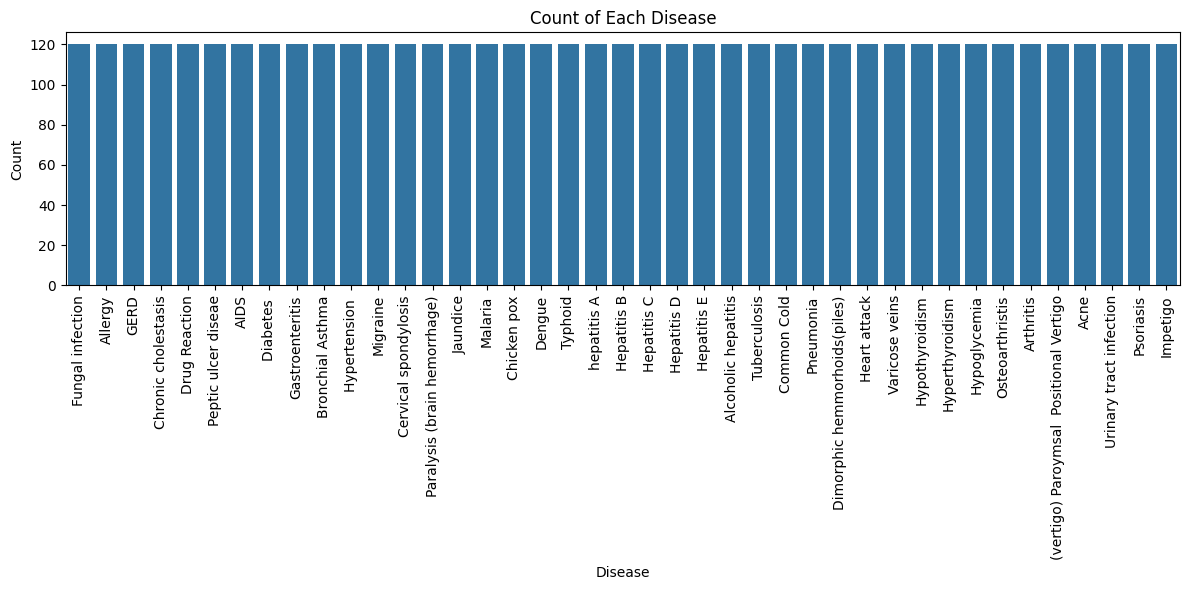

In [16]:
# Checking if the data balanced or not:
plt.figure(figsize=(12, 6))
sns.countplot(data=df_encoded, x='Disease', order=df_encoded['Disease'].value_counts().index)
plt.xticks(rotation=90)
plt.title("Count of Each Disease")
plt.xlabel("Disease")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

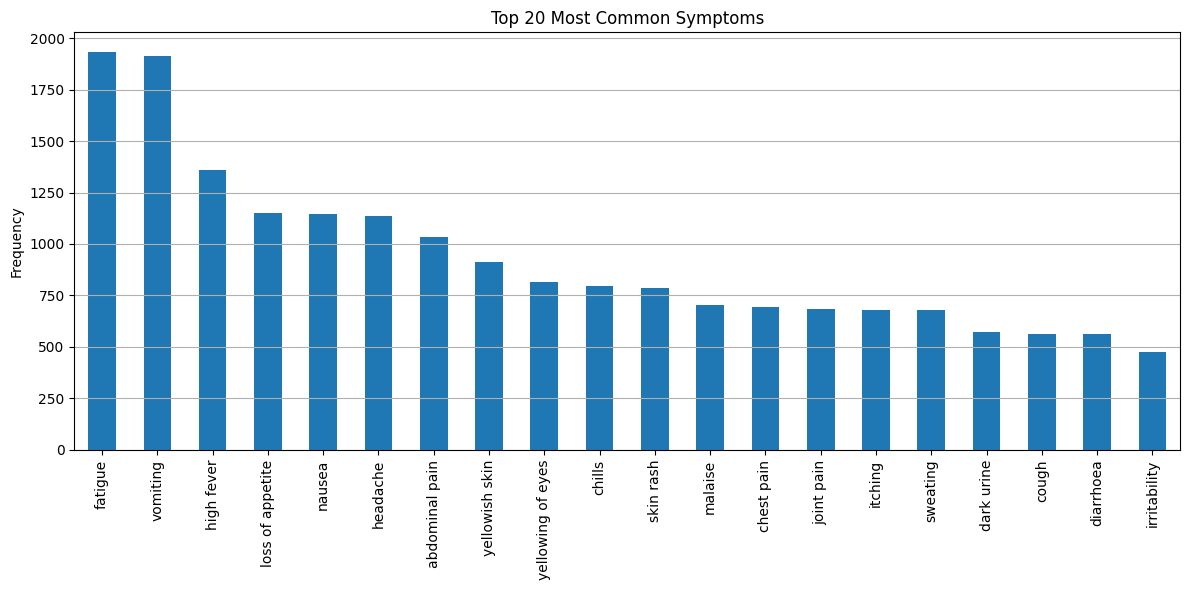

In [17]:
symptom_cols = df_encoded.columns.difference(['Disease'])
symptom_counts = df_encoded[symptom_cols].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
symptom_counts.head(20).plot(kind='bar')
plt.title("Top 20 Most Common Symptoms")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

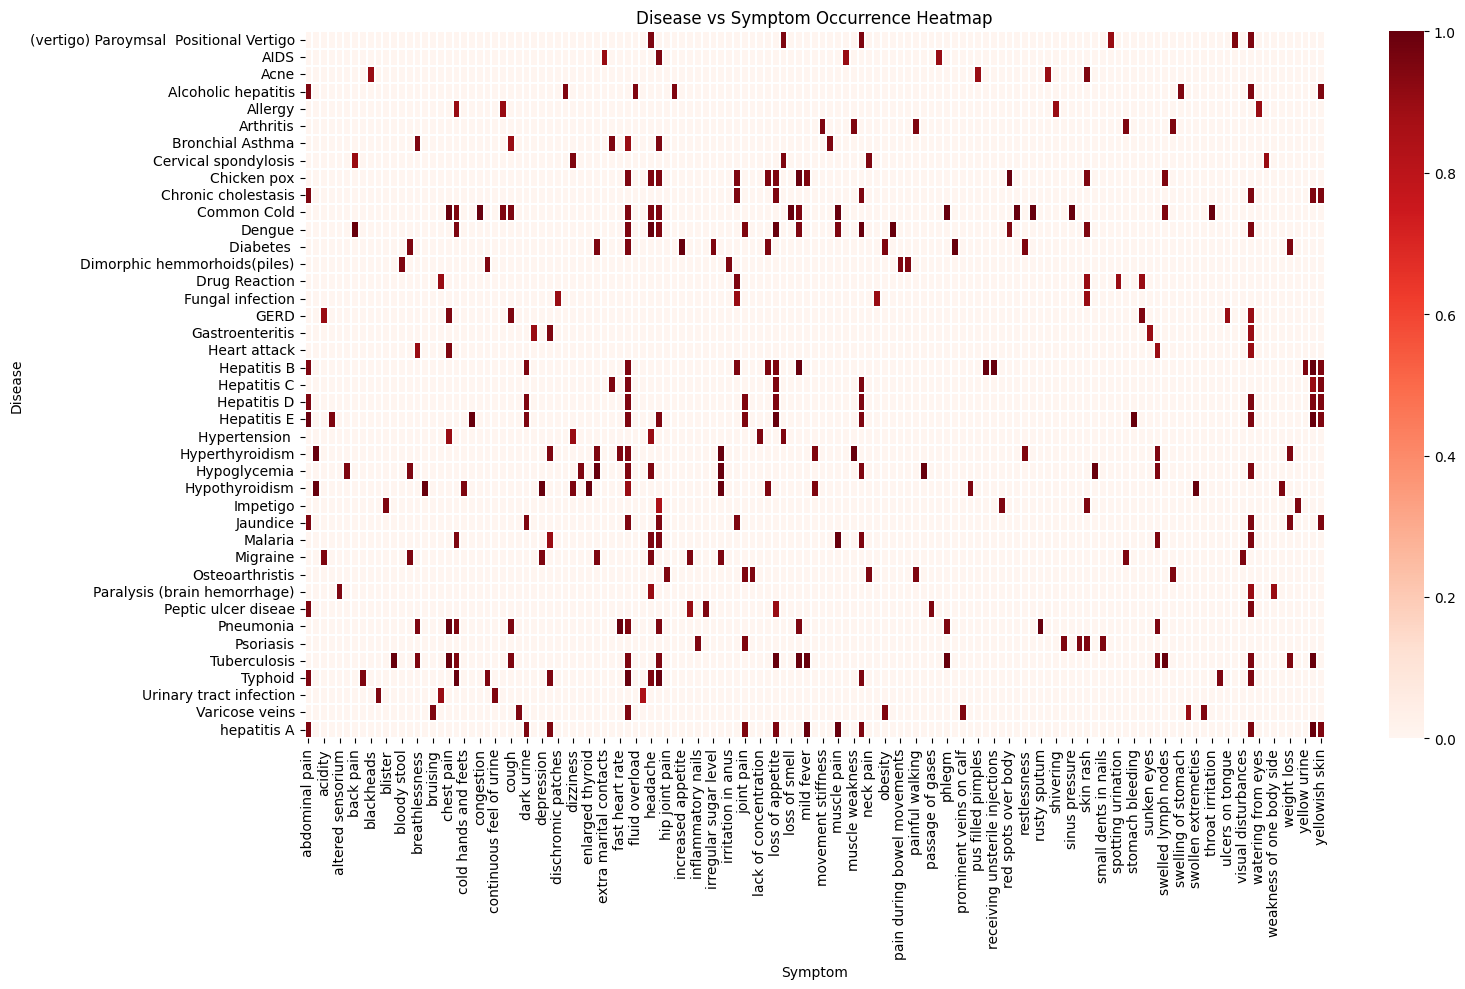

In [18]:
disease_symptom_matrix = df_encoded.groupby('Disease')[symptom_cols].mean()
plt.figure(figsize=(16, 10))
sns.heatmap(disease_symptom_matrix, cmap="Reds", linewidths=0.3,)
plt.title("Disease vs Symptom Occurrence Heatmap")
plt.xlabel("Symptom")
plt.ylabel("Disease")
plt.tight_layout()
plt.show()

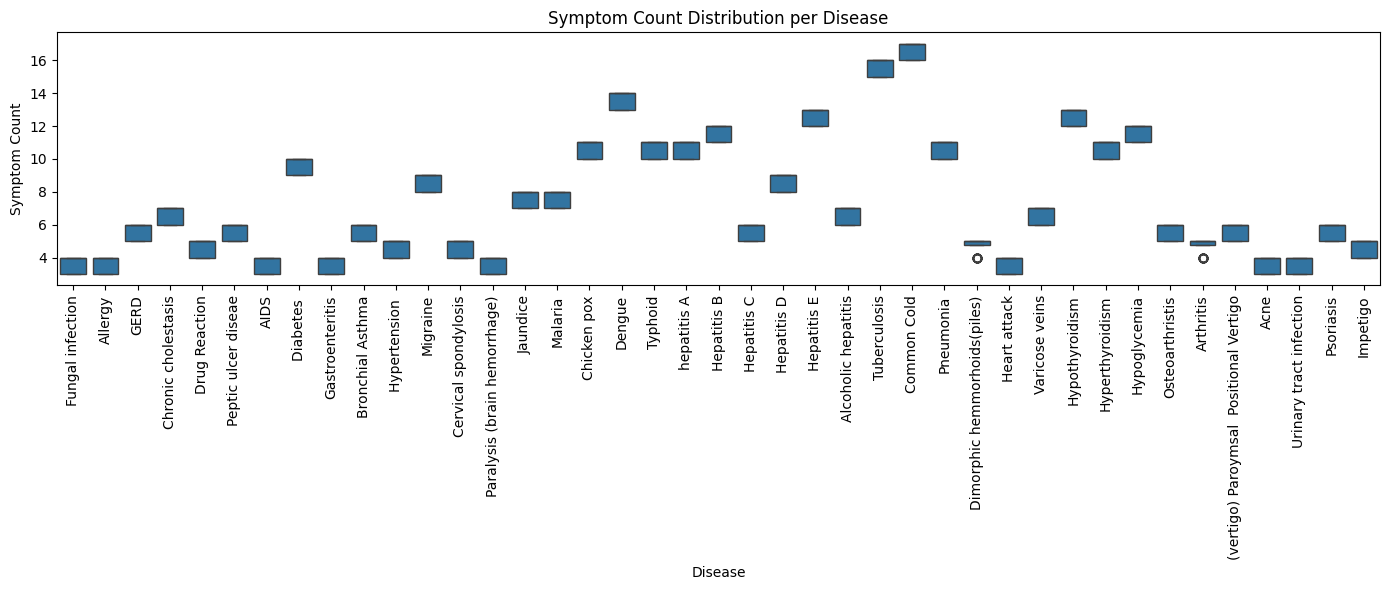

In [19]:
df_encoded['Symptom Count'] = df_encoded[symptom_cols].sum(axis=1)
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_encoded, x='Disease', y='Symptom Count')
plt.xticks(rotation=90)
plt.title("Symptom Count Distribution per Disease")
plt.tight_layout()
plt.show()

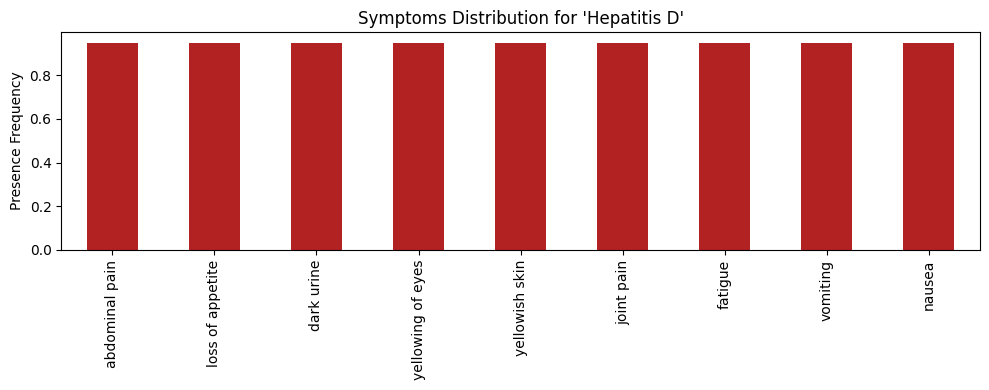

In [20]:
def plot_disease_symptoms(disease_name):
    rows = df_encoded[df_encoded['Disease'] == disease_name]
    means = rows[symptom_cols].mean().sort_values(ascending=False)

    plt.figure(figsize=(10, 4))
    means[means > 0].plot(kind='bar', color='firebrick')
    plt.title(f"Symptoms Distribution for '{disease_name}'")
    plt.xticks(rotation=90)
    plt.ylabel("Presence Frequency")
    plt.tight_layout()
    plt.show()

plot_disease_symptoms("Hepatitis D")

In [21]:
# drop it because it make for the analysis above:
df_encoded = df_encoded.drop(columns=['Symptom Count'], errors='ignore')

In [22]:
# Number of symptoms (columns used for one-hot encoding)
symptom_cols = df_encoded.columns.difference(['Disease'])
print("Number of symptoms used to identify the disease:", len(symptom_cols))
print("Number of diseases that can be identified:", df_encoded['Disease'].nunique())

Number of symptoms used to identify the disease: 131
Number of diseases that can be identified: 41


In [23]:
# 1. Split data
X = df_encoded.drop('Disease', axis=1)
y = df_encoded['Disease']

In [24]:
# 2. Separate data 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3936, 131) (984, 131) (3936,) (984,)


In [25]:
#Defining scoring metric for k-fold cross validation
def cv_scoring(estimator, X, y):
    return accuracy_score(y, estimator.predict(X))

#Initializing Models
models = {
    "Random Forest":RandomForestClassifier(random_state=42, max_features='sqrt', n_estimators= 500, max_depth=13),
}

#Producing cross validation score for the models
for model_name in models:
    model = models[model_name]
    scores = cross_val_score(model, X_test, y_test, cv = 10, n_jobs=-1, scoring = cv_scoring)
    print("=="*30)
    print(model_name)
    print(f"Scores:{scores*100.0}")
    print(f"Mean_score:{np.mean(scores)*100.0}")
    print(f"Standard_Divation Score:{np.std(scores)*100.0}")

Random Forest
Scores:[100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
Mean_score:100.0
Standard_Divation Score:0.0


F1-score% = 100.0 | Accuracy on test = 100.0 | Accuracy on train = 100.0


<Axes: >

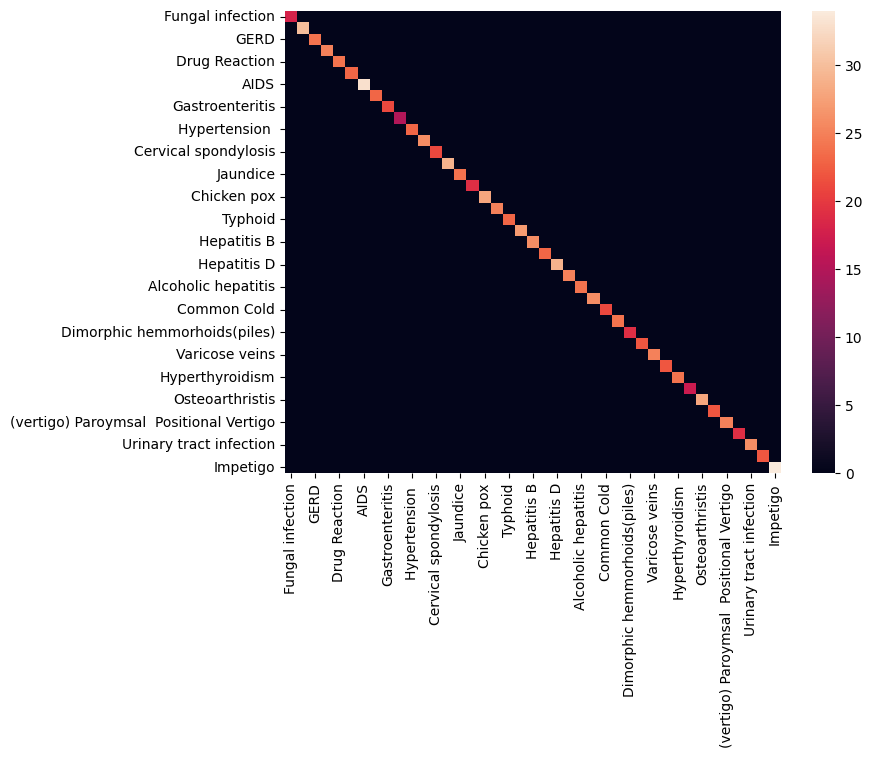

In [26]:
#Train RandomForestClassifier Model
rf_model = RandomForestClassifier(random_state=42, max_features='sqrt', n_estimators= 500, max_depth=13)
rf_model.fit(X_train,y_train)
preds=rf_model.predict(X_test)
conf_mat = confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(conf_mat, index=df_encoded['Disease'].unique(), columns=df_encoded['Disease'].unique())
print('F1-score% =', f1_score(y_test, preds, average='macro')*100, '|', 'Accuracy on test =', accuracy_score(y_test, preds)*100, '|', 'Accuracy on train =', accuracy_score(y_train, rf_model.predict(X_train))*100)
plt.figure(figsize=(8,6))
sns.heatmap(df_cm)

In [27]:
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 13, 15],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

best_rf = grid_search.best_estimator_

from sklearn.metrics import classification_report

y_pred = best_rf.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best Cross-Validation Accuracy: 1.0
Test Accuracy: 1.0
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        18
                                   AIDS       1.00      1.00      1.00        30
                                   Acne       1.00      1.00      1.00        24
                    Alcoholic hepatitis       1.00      1.00      1.00        25
                                Allergy       1.00      1.00      1.00        24
                              Arthritis       1.00      1.00      1.00        23
                       Bronchial Asthma       1.00      1.00      1.00        33
                   Cervical spondylosis       1.00      1.00      1.00        23
                          

In [28]:
description  = pd.read_csv("/content/symptom_Description.csv")
description.head()

,Disease,Description
0,Drug Reaction,An adverse drug reaction (ADR) is an injury ca...
1,Malaria,An infectious disease caused by protozoan para...
2,Allergy,An allergy is an immune system response to a f...
3,Hypothyroidism,"Hypothyroidism, also called underactive thyroi..."
4,Psoriasis,Psoriasis is a common skin disorder that forms...


In [29]:
preacution = pd.read_csv("/content/symptom_precaution.csv")
preacution.head()

,Disease,Precaution_1,Precaution_2,Precaution_3,Precaution_4
0,Drug Reaction,stop irritation,consult nearest hospital,stop taking drug,follow up
1,Malaria,Consult nearest hospital,avoid oily food,avoid non veg food,keep mosquitos out
2,Allergy,apply calamine,cover area with bandage,NaN,use ice to compress itching
3,Hypothyroidism,reduce stress,exercise,eat healthy,get proper sleep
4,Psoriasis,wash hands with warm soapy water,stop bleeding using pressure,consult doctor,salt baths


In [30]:
disease_info_df = pd.merge(description, preacution, on='Disease', how='inner')
disease_info_df

,Disease,Description,Precaution_1,Precaution_2,Precaution_3,Precaution_4
0,Drug Reaction,An adverse drug reaction (ADR) is an injury ca...,stop irritation,consult nearest hospital,stop taking drug,follow up
1,Malaria,An infectious disease caused by protozoan para...,Consult nearest hospital,avoid oily food,avoid non veg food,keep mosquitos out
2,Allergy,An allergy is an immune system response to a f...,apply calamine,cover area with bandage,NaN,use ice to compress itching
3,Hypothyroidism,"Hypothyroidism, also called underactive thyroi...",reduce stress,exercise,eat healthy,get proper sleep
4,Psoriasis,Psoriasis is a common skin disorder that forms...,wash hands with warm soapy water,stop bleeding using pressure,consult doctor,salt baths
5,GERD,"Gastroesophageal reflux disease, or GERD, is a...",avoid fatty spicy food,avoid lying down after eating,maintain healthy weight,exercise
6,Chronic cholestasis,"Chronic cholestatic diseases, whether occurrin...",cold baths,anti itch medicine,consult doctor,eat healthy
7,hepatitis A,Hepatitis A is a highly contagious liver infec...,Consult nearest hospital,wash hands through,avoid fatty spicy food,medication
8,Osteoarthristis,Osteoarthritis is the most common form of arth...,acetaminophen,consult nearest hospital,follow up,salt baths
9,(vertigo) Paroymsal Positional Vertigo,Benign paroxysmal positional vertigo (BPPV) is...,lie down,avoid sudden change in body,avoid abrupt head movment,relax


In [31]:
def clean_input(symptom_string):
    tokens = [s.strip().lower() for s in symptom_string.split(',')]
    return list(set(tokens))

def symptoms_to_vector(symptom_list, mlb):
    all_symptoms = mlb.classes_
    vector = [1 if symptom in symptom_list else 0 for symptom in all_symptoms]
    return pd.DataFrame([vector], columns=all_symptoms)

def predict_disease(user_input, model, mlb, info_df):
    cleaned = clean_input(user_input)
    input_vector = symptoms_to_vector(cleaned, mlb)
    prediction = best_rf.predict(input_vector)[0]

    row = info_df[info_df['Disease'] == prediction].iloc[0]
    description = row['Description']
    precautions = [row[c] for c in info_df.columns if 'Precaution' in c and pd.notna(row[c])]

    print(f"\nPredicted Disease: {prediction}\n")
    print(f"Description:\n{description}\n")
    print("Precautions:")
    for i, p in enumerate(precautions, 1):
        print(f"  {i}. {p}")

# Example usage
print("="*50)
user_input = "voimting, sweating, chest pain"
predict_disease(user_input, best_rf, mlb, disease_info_df)
print("="*50)
user_input = "muscle waekness, stiff neck, swelling joints, movement stiffness"
predict_disease(user_input, best_rf, mlb, disease_info_df)
print("="*50)
user_input = "joint pain, vomiting, yellowish skin, dark urine, nausea, loss of appetite, abdominal pain, muscle pain"
predict_disease(user_input, best_rf, mlb, disease_info_df)
print("="*50)
user_input = "acidity, anxiety, blister"
predict_disease(user_input, best_rf, mlb, disease_info_df)


Predicted Disease: Heart attack

Description:
The death of heart muscle due to the loss of blood supply. The loss of blood supply is usually caused by a complete blockage of a coronary artery, one of the arteries that supplies blood to the heart muscle.

Precautions:
  1. call ambulance
  2. chew or swallow asprin
  3. keep calm

Predicted Disease: Arthritis

Description:
Arthritis is the swelling and tenderness of one or more of your joints. The main symptoms of arthritis are joint pain and stiffness, which typically worsen with age. The most common types of arthritis are osteoarthritis and rheumatoid arthritis.

Precautions:
  1. exercise
  2. use hot and cold therapy
  3. try acupuncture
  4. massage

Predicted Disease: hepatitis A

Description:
Hepatitis A is a highly contagious liver infection caused by the hepatitis A virus. The virus is one of several types of hepatitis viruses that cause inflammation and affect your liver's ability to function.

Precautions:
  1. Consult neare

In [50]:
# testing on unseen data:
user_input = "sweating, nausea, discomfort, fainting"
predict_disease(user_input, best_rf, mlb, disease_info_df)


Predicted Disease: Heart attack

Description:
The death of heart muscle due to the loss of blood supply. The loss of blood supply is usually caused by a complete blockage of a coronary artery, one of the arteries that supplies blood to the heart muscle.

Precautions:
  1. call ambulance
  2. chew or swallow asprin
  3. keep calm


In [54]:
#testing on unseen data
user_input = "fever, redness, breathlessness, skin rash, dischromic patches, itching"
predict_disease(user_input, best_rf, mlb, disease_info_df)


Predicted Disease: Fungal infection

Description:
In humans, fungal infections occur when an invading fungus takes over an area of the body and is too much for the immune system to handle. Fungi can live in the air, soil, water, and plants. There are also some fungi that live naturally in the human body. Like many microbes, there are helpful fungi and harmful fungi.

Precautions:
  1. bath twice
  2. use detol or neem in bathing water
  3. keep infected area dry
  4. use clean cloths


In [32]:
import joblib
joblib.dump(rf_model, 'rf_model.pkl')
joblib.dump(best_rf, 'best_rf_model.pkl')
joblib.dump(mlb, 'symptom_encoder.pkl')

['symptom_encoder.pkl']